<a href="https://colab.research.google.com/github/makkimaki/pytorch_official_tutorial/blob/main/pytorch_tutorial_5_automatic_differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic differentiaton with `torch.autograd`


In [2]:
import torch 

x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b

loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## Tensors, Functions and Computational graph
------------------------------------------

This code defines the following **computational graph**:

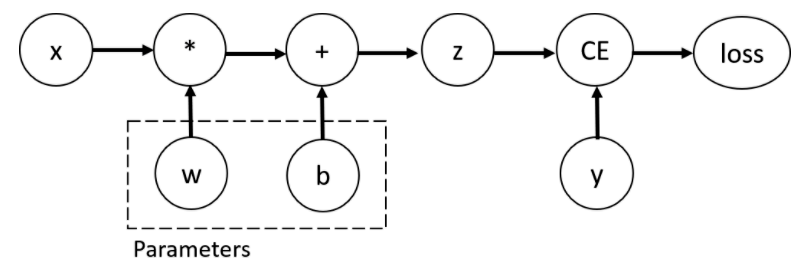

In this network, ``w`` and ``b`` are **parameters**, which we need to
optimize. Thus, we need to be able to compute the gradients of loss
function with respect to those variables. In order to do that, we set
the ``requires_grad`` property of those tensors.



> `requires_grad`は，テンソルの定義時の引数設定以外にも，`x.requires_grad_(True)`と設定できる．

   
   

テンソルに適用して計算グラフを構築する関数たちは，`Function`クラスに属するオブジェクトとなる．これは*順方向*の計算法を構築する．また，逆伝播ステップ時の微分も計算できるようになる．逆伝播関数へのリファレンスは，テンソルの`grad_fn`プロパティにある．



In [3]:
print("Gradient function for z = ", z.grad_fn)
print("Gradient function for loss = ", loss.grad_fn)

Gradient function for z =  <AddBackward0 object at 0x7f43746ea610>
Gradient function for loss =  <BinaryCrossEntropyWithLogitsBackward object at 0x7f43746eab50>


## 勾配の計算

In [4]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1170, 0.0109, 0.3109],
        [0.1170, 0.0109, 0.3109],
        [0.1170, 0.0109, 0.3109],
        [0.1170, 0.0109, 0.3109],
        [0.1170, 0.0109, 0.3109]])
tensor([0.1170, 0.0109, 0.3109])




> - `grad`プロパティは，計算グラフの葉っぱノード(leaf node)でのみ使えて，`requires_grad=True`としておかないといけない．
> - 計算グラフに対して，`backward`を使った勾配計算は一度のみ可能（パフォーマンス的理由から）．同じグラフに対して何度も`backward`を呼び出すことがあるなら`backward`呼び出し時に`retain_graph=True`を設定する．



## Disabling Gradient Tracking
勾配のトラッキングが必要なくなる時もある．
そういう時は，計算コード(computation code)をwith `torch.no_grad()`ブロックで囲む．

In [6]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


  他の方法は，テンソル上で`detach()`メソッドを使う.

In [7]:
z = torch.matmul(x, w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


勾配トラッキングを停止したい理由はいくつか考えられる
- ニューラルネット中のパラメータをフリーズさせたい．例えば，事前学習済みモデルをファインチューニングしたい時．
- 順伝播の時にスピードアップしたい．

## More on Computational Graphs
概念的には，autogradはデータ（tensors）と全ての実行された操作（結果の新しいtensorsも）がDAG(directed acyclic graph)に保存される．このDAGは`Function`オブジェクトを構成している．
DAG中では，葉っぱ(leaves)はインプットテンソルであり，根っこ(roots)はアウトプットテンソルになる．根から葉をトレースすることでチェインルールで勾配を自動的に計算できる．
  
順伝播では，`autograd`は２つのことを同時に行ってくれる．
- run the requested operation to compute a resulting tensor
- maintain the operation's *`gradient function`* in the DAG.

逆伝播はDAGの根で`.backward()`が実行された時に開始する．`autograd`はこの時に
- computes the gradients from each `.grad_fn`
- accumulates them in the respective tensor's `.grad` attribute
- using the chain rule, propagates all the way to the leaf tensors.

